# **Animations Presentation**

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation, rc
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from cartopy import crs, feature

from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D

rc('animation', html='html5')
from IPython.display import HTML, Video

## Functions

#### Path prefix

In [2]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results2/SalishSea/nowcast-green.201905/daymonthyear/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    folder = date.strftime("%d%b%y").lower()
    prefix = os.path.join(path, f'{folder}/SalishSea_1{res}_{datestr}')
    
    return prefix

#### Scatter_Colors

In [3]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatter_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5))
    return scatter

#### Useful Kernel

In [4]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

In [5]:
def Buoyancy(particle, fieldset, time):
    '''Stokes law settling velocity and critical sinking velocity'''
    Rp = 960 #Density particle: PE (~960 kg/m3 ),PS (~150 kg/m3), PET (~1370 kg/m3).
    ESD=5e-5 #Size particle (ESD) equivalent spherical diameter
    #visc=1e-3 #average viscosity sea water
     
    z = particle.depth
    u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    if  u == 0:
        dz = 0
    else:
        
        a = -0.15
        b = 0.78
        k=4.5e-3
        pa=10.13
        ro0 = 1027
        t0 = 10
        s0 = 35
        g = 9.8
        t = fieldset.T[time, particle.depth, particle.lat, particle.lon]
        s = fieldset.S[time, particle.depth, particle.lat, particle.lon]
        p = ((g*z*ro0)/1e4)+pa
        ro = ro0 + a*(t-t0) + b*(s-s0) + k*p
        visc = 4.2844e-5 + 1/(0.157*((t + 64.993)**2)-91.296)
        Ws= ((ESD**2)*g*(Rp-ro))/(18*visc)
        WWS =(11.68 + 0.1991*ESD*1e6 + 0.0004*(ESD*1e6)**2- 0.0993*(Rp-ro) + 0.0002*(Rp-ro)**2)/86400
        
    if Ws>WWS:
        dz = WWS*particle.dt
    else:
        dz = Ws*particle.dt
    if dz+z > 0:
        particle.depth += dz
    else:
        particle.depth = 0.5

## Load drifters and definitions

In [6]:
# Define paths
paths = {
    'NEMO': '/results2/SalishSea/nowcast-green.201905/',
    'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/ocean/jvalenti/MOAD/grid/mesh_mask201702.nc',
    'out': '/home/jvalenti/MOAD/analysis-jose/notebooks/results',
    'anim': '/home/jvalenti/MOAD/animations'
}

In [8]:
# Duration and timestep [s]
length = 30
duration = timedelta(days=length)
dt = timedelta(minutes=2)

In [9]:
def zdep(dmin,dd):
    if isinstance(dmin,int):
        zvals1 = dmin + np.random.random_sample([n,N]).T*(dd)
    else:
        zvals = []
        zvals1 = []
        for dept in dmin:
            zvals.append(dept + np.random.random_sample([n]).T*(dd))
        for i in range(len(zvals)):   
            zvals1=np.concatenate((zvals1[:],zvals[i]))
    return zvals1   

In [10]:
N = 6 # number of deploying locations
n = 100 # 1000   # number of particles per location
# Define Gaussian point cloud in the horizontal
r = 1000   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
# Set a uniform distribution in depth, from dmin to dmax
dmin = [0,0,0,0,0,70]
dd = 20
zvals = zdep(dmin,dd)

## Simulation

In [11]:
start = datetime(2018, 8, 1)
daterange = [start+timedelta(days=i) for i in range(length)]
# Build filenames
Ulist, Vlist, Wlist = [], [], []
Tlist= []
for day in range(duration.days):
    path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
    print (path_NEMO)
    Ulist.append(path_NEMO + '_grid_U.nc')
    Vlist.append(path_NEMO + '_grid_V.nc')
    Wlist.append(path_NEMO + '_grid_W.nc')
    Tlist.append(path_NEMO + '_grid_T.nc')

# Load NEMO forcing : note, depth aware but no vertical advection, particles stay at their original depth
filenames = {
    'U': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Ulist},
    'V': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Vlist},
    'W': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Wlist},
    'T': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist},
    'S': {'lon': paths['coords'], 'lat': paths['coords'], 'depth': Wlist[0], 'data': Tlist},
}
variables = {'U': 'vozocrtx', 'V': 'vomecrty','W': 'vovecrtz','T':'votemper','S':'vosaline'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}

#bring salish sea results into field_set
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

/results2/SalishSea/nowcast-green.201905/01aug18/SalishSea_1h_20180801_20180801
/results2/SalishSea/nowcast-green.201905/02aug18/SalishSea_1h_20180802_20180802
/results2/SalishSea/nowcast-green.201905/03aug18/SalishSea_1h_20180803_20180803
/results2/SalishSea/nowcast-green.201905/04aug18/SalishSea_1h_20180804_20180804
/results2/SalishSea/nowcast-green.201905/05aug18/SalishSea_1h_20180805_20180805
/results2/SalishSea/nowcast-green.201905/06aug18/SalishSea_1h_20180806_20180806
/results2/SalishSea/nowcast-green.201905/07aug18/SalishSea_1h_20180807_20180807
/results2/SalishSea/nowcast-green.201905/08aug18/SalishSea_1h_20180808_20180808
/results2/SalishSea/nowcast-green.201905/09aug18/SalishSea_1h_20180809_20180809
/results2/SalishSea/nowcast-green.201905/10aug18/SalishSea_1h_20180810_20180810
/results2/SalishSea/nowcast-green.201905/11aug18/SalishSea_1h_20180811_20180811
/results2/SalishSea/nowcast-green.201905/12aug18/SalishSea_1h_20180812_20180812
/results2/SalishSea/nowcast-green.201905

         It will be opened with no decoding. Filling values might be wrongly parsed.


### Change name for each run!!

In [12]:
# Set output file name.  Maybe change for each run
fn = f'PEsummer' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/PEsummer20180801_1n_20180831_1n.nc


In [13]:
Dat=xr.open_dataset('/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]

### Set particle location

In [14]:
lon = np.zeros([N,n])
lat = np.zeros([N,n])
# Execute run
clon, clat = [-123.901172,-125.155849,-123.207648,-122.427508,-123.399769,float(outf_lon)], [49.186308,49.975326,49.305448,47.622403,48.399420,float(outf_lat)]  # choose horizontal centre of the particle cloud
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
z = zvals

In [15]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, depth=z, time=start+timedelta(hours=2))

p_flt = pset.Kernel(Buoyancy) 

pset.execute(AdvectionRK4_3D + p_flt, 
             runtime=duration, 
             dt=dt,
             output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvectionRK4_3DBuoyancy ==> /tmp/parcels-2894/libfff61ef1e364c7a5ada202cd62a6845d_0.so
INFO: Temporary output files are stored in /home/jvalenti/MOAD/analysis-jose/notebooks/results/out-THSHCSVU.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jvalenti/MOAD/analysis-jose/notebooks/results/out-THSHCSVU" to convert these to a NetCDF file during the run.
  3% (82800.0 of 2592000.0) |            | Elapsed Time: 0:00:49 ETA:   0:27:43

Particle 1 lost !! [-124.00751219470283, 49.30331466300849, 9.258289611225462e-07, 89760.0]


  9% (252000.0 of 2592000.0) |#          | Elapsed Time: 0:02:49 ETA:   0:27:01

Particle 386 lost !! [-122.38116043498978, 47.88180546026454, 8.438152365279616e-07, 258240.0]


 15% (388800.0 of 2592000.0) |#          | Elapsed Time: 0:04:24 ETA:   0:24:41

Particle 438 lost !! [-124.79472049993446, 48.51678623230629, 0.4823754122641283, 395280.0]


 16% (417600.0 of 2592000.0) |#          | Elapsed Time: 0:04:44 ETA:   0:28:42

Particle 467 lost !! [-124.8116133041455, 48.53691602435883, 0.37634299572697466, 423000.0]
Particle 475 lost !! [-124.79491144128849, 48.51701352223489, 0.09350338906389502, 423480.0]


 17% (450000.0 of 2592000.0) |#          | Elapsed Time: 0:05:10 ETA:   0:28:34

Particle 400 lost !! [-124.8308320400737, 48.55979866563177, 0.4734845476155833, 456480.0]


 17% (453600.0 of 2592000.0) |#          | Elapsed Time: 0:05:13 ETA:   0:30:11

Particle 457 lost !! [-124.83290519406616, 48.5622670441869, 0.23481763647036105, 460440.0]


 17% (455400.0 of 2592000.0) |#          | Elapsed Time: 0:05:16 ETA:   0:56:23

Particle 406 lost !! [-124.83491423644149, 48.56465908899227, 0.15524649536580243, 462360.0]
Particle 407 lost !! [-124.83350103171695, 48.562976471892036, 0.17294494514477524, 460920.0]
Particle 443 lost !! [-124.83490418514589, 48.56464712148353, 0.23479810577564308, 462360.0]
Particle 450 lost !! [-124.83501774436607, 48.56478232954034, 0.20827941538494915, 462480.0]
Particle 485 lost !! [-124.83492263568431, 48.56466908983841, 0.12872941178237252, 462360.0]


 17% (462600.0 of 2592000.0) |#          | Elapsed Time: 0:05:23 ETA:   0:55:16

Particle 412 lost !! [-124.74460763963032, 48.4570389709272, 0.49110379240606017, 469440.0]


 17% (464400.0 of 2592000.0) |#          | Elapsed Time: 0:05:24 ETA:   0:32:48

Particle 419 lost !! [-124.84489253251229, 48.57653584010304, 0.33223024063553697, 470160.0]


 17% (466200.0 of 2592000.0) |#          | Elapsed Time: 0:05:26 ETA:   0:52:44

Particle 497 lost !! [-124.85166276211228, 48.58458918974539, 1.6893533660916433, 472440.0]


 18% (469800.0 of 2592000.0) |#          | Elapsed Time: 0:05:29 ETA:   0:46:49

Correct cell not found for (-124.795020, 48.517143) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 419 0
            new particle indices: (yi, xi) 419 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4041864849577102e+01 9.9092364978058300e-01
Correct cell not found for (-124.811654, 48.536964) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 425 0
            new particle indices: (yi, xi) 424 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.2989796591947332e+01 9.5845950866837371e-01
Correct cell not found for (-124.795034, 48.517160) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 419 0
            new particle indices: (yi, xi) 419 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4042751124149937e+01 -4.8182237633113906e-03
Correct cell not found for (-124.830876, 48.559851) after 1000000 

 18% (475200.0 of 2592000.0) |##         | Elapsed Time: 0:05:33 ETA:   0:29:56

Particle 455 lost !! [-124.80818073863892, 48.53281998670419, 0.02027910338837558, 481320.0]


 18% (486000.0 of 2592000.0) |##         | Elapsed Time: 0:05:43 ETA:   0:33:46

Particle 425 lost !! [-124.76149818479644, 48.47718177082684, 0.09029341361373593, 492960.0]


 19% (514800.0 of 2592000.0) |##         | Elapsed Time: 0:06:09 ETA:   0:30:24

Particle 487 lost !! [-124.83824537588325, 48.56862161478188, 15.569587993369986, 521280.0]


 20% (527400.0 of 2592000.0) |##         | Elapsed Time: 0:06:23 ETA:   1:06:24

Particle 462 lost !! [-124.83834174208899, 48.56873623402204, 30.804181171932612, 533280.0]


 20% (543600.0 of 2592000.0) |##         | Elapsed Time: 0:06:36 ETA:   0:30:36

Particle 470 lost !! [-124.84493406068398, 48.57658527123047, 26.930407879689124, 549720.0]


 21% (550800.0 of 2592000.0) |##         | Elapsed Time: 0:06:42 ETA:   0:27:20

Particle 411 lost !! [-124.8516112417497, 48.58452790154087, 0.4468919600802755, 556320.0]
Particle 426 lost !! [-124.85169406994078, 48.58462642528718, 35.792866838935204, 557400.0]
Particle 430 lost !! [-124.76147211204774, 48.47715073250955, 0.22458548814209744, 557400.0]
Particle 452 lost !! [-124.86165916293498, 48.596483711132386, 5.785965552898369, 556200.0]


 21% (552600.0 of 2592000.0) |##         | Elapsed Time: 0:06:45 ETA:   1:00:06

) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 415 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4027757554018990e+01 1.0102207597850474e+00
Correct cell not found for (-124.778248, 48.497153) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 414 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4026796208412044e+01 9.9067814891700978e-01
Correct cell not found for (-124.855121, 48.588707) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 438 0
            new particle indices: (yi, xi) 438 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3024421594445649e+01 1.0173889266346747e+00
Correct cell not found for (-124.808356, 48.533029) after 1000000 iterations
Debug info: old particle indices: (yi, x

 21% (558000.0 of 2592000.0) |##         | Elapsed Time: 0:06:49 ETA:   0:30:15

Particle 435 lost !! [-124.83492162801672, 48.56466789768167, 0.36666720457340174, 564000.0]
Particle 479 lost !! [-124.79477677857713, 48.51685321676119, 0.4286905284989902, 565080.0]


 21% (561600.0 of 2592000.0) |##         | Elapsed Time: 0:06:53 ETA:   0:34:57

Particle 436 lost !! [-124.80492093744091, 48.52893502799959, 0.08113924442198103, 568200.0]
Particle 465 lost !! [-124.8049359927127, 48.52895297202459, 0.11680529692396946, 567840.0]


 22% (586800.0 of 2592000.0) |##         | Elapsed Time: 0:07:16 ETA:   0:36:13

Particle 408 lost !! [-124.81162646418397, 48.536931729763445, 0.17907871638677583, 593400.0]
Particle 439 lost !! [-124.81161688343761, 48.53692028965051, 23.683842460989794, 592560.0]


 22% (588600.0 of 2592000.0) |##         | Elapsed Time: 0:07:19 ETA:   1:04:53

Particle 437 lost !! [-124.8115973190254, 48.53689694501064, 0.20585073476783275, 594960.0]


 23% (601200.0 of 2592000.0) |##         | Elapsed Time: 0:07:31 ETA:   0:35:17

Particle 427 lost !! [-124.83498959948022, 48.56474882888919, 0.23291423710015818, 607560.0]


 23% (603000.0 of 2592000.0) |##         | Elapsed Time: 0:07:34 ETA:   1:02:24

Particle 428 lost !! [-124.83828411891083, 48.568667708255, 0.4287543145314374, 609720.0]


 24% (635400.0 of 2592000.0) |##         | Elapsed Time: 0:08:03 ETA:   0:53:25

Particle 261 lost !! [-123.23983570970539, 49.34017257684333, 1.3821973440797386e-08, 642480.0]


 24% (640800.0 of 2592000.0) |##         | Elapsed Time: 0:08:07 ETA:   0:32:06

Particle 433 lost !! [-124.72477745124493, 48.43338511055215, 0.05771861496062491, 646560.0]


 24% (642600.0 of 2592000.0) |##         | Elapsed Time: 0:08:10 ETA:   0:54:16

Particle 448 lost !! [-124.7777459567427, 48.49655453041434, 0.054190785767016074, 649680.0]


 25% (648000.0 of 2592000.0) |##         | Elapsed Time: 0:08:13 ETA:   0:27:37

Particle 491 lost !! [-124.79446743864014, 48.51648485898251, 0.16074087332661627, 654840.0]


 25% (651600.0 of 2592000.0) |##         | Elapsed Time: 0:08:17 ETA:   0:29:46

 indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 415 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4024224028136146e+01 5.9645759539166961e-02
Correct cell not found for (-124.835101, 48.564881) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 431 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3001356551922925e+01 -4.2342042249640360e-02
Correct cell not found for (-124.795011, 48.517132) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 419 0
            new particle indices: (yi, xi) 419 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4041672794516224e+01 9.8814552889609741e-01
Correct cell not found for (-124.805169, 48.529230) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 422 0
            new particle indices: (yi, xi

 26% (684000.0 of 2592000.0) |##         | Elapsed Time: 0:08:47 ETA:   0:43:34

Particle 410 lost !! [-124.81158194542527, 48.536878657052625, 0.4013619393302337, 689520.0]


 26% (687600.0 of 2592000.0) |##         | Elapsed Time: 0:08:51 ETA:   0:32:52

Particle 424 lost !! [-124.82705494361188, 48.55530150627543, 0.15017284998374703, 694560.0]


 26% (689400.0 of 2592000.0) |##         | Elapsed Time: 0:08:55 ETA:   1:08:56

Particle 403 lost !! [-124.83022914538068, 48.55908083554477, 0.28472841222879963, 696360.0]


 26% (693000.0 of 2592000.0) |##         | Elapsed Time: 0:09:00 ETA:   1:12:29

Particle 446 lost !! [-124.83498612649832, 48.56474468664219, 16.41547593738856, 700080.0]
Particle 474 lost !! [-124.8326814404609, 48.562000634364104, 15.564237056467343, 699000.0]


 28% (730800.0 of 2592000.0) |###        | Elapsed Time: 0:09:33 ETA:   0:30:36

Particle 456 lost !! [-124.74449712873765, 48.4569074340035, 0.16775231446073563, 736680.0]
Particle 499 lost !! [-124.72136499332578, 48.42930520144972, 1.6838063278152202, 736440.0]


 28% (739800.0 of 2592000.0) |###        | Elapsed Time: 0:09:44 ETA:   1:01:09

Particle 413 lost !! [-124.7346803802452, 48.445203591139645, 0.10687350007392789, 745560.0]


 28% (743400.0 of 2592000.0) |###        | Elapsed Time: 0:09:48 ETA:   1:00:33

Particle 495 lost !! [-124.81122143034374, 48.5364484964049, 0.3465414398049525, 749880.0]


 29% (757800.0 of 2592000.0) |###        | Elapsed Time: 0:10:04 ETA:   1:04:36

Particle 417 lost !! [-124.93863212982637, 48.68796990651072, 0.06184129009988539, 763920.0]


 31% (824400.0 of 2592000.0) |###        | Elapsed Time: 0:11:17 ETA:   0:35:16

Particle 423 lost !! [-124.8382513332737, 48.568628729444164, 41.64350972646079, 829920.0]


 31% (828000.0 of 2592000.0) |###        | Elapsed Time: 0:11:23 ETA:   0:45:38

Particle 490 lost !! [-124.80492755968612, 48.52894295662623, 0.10943863343293048, 833520.0]


 32% (829800.0 of 2592000.0) |###        | Elapsed Time: 0:11:27 ETA:   0:58:19

ndices: (yi, xi) 448 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3054809267772484e+01 9.8259102505300577e-01
Correct cell not found for (-124.811689, 48.537006) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 425 0
            new particle indices: (yi, xi) 424 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.2989300710060981e+01 9.6866132597990096e-01
Correct cell not found for (-124.827386, 48.555696) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 429 0
            new particle indices: (yi, xi) 429 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3029655700488874e+01 6.7016580460025366e-01
Correct cell not found for (-124.830546, 48.559459) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 430 0
            new particle indices: (yi, xi) 430 42
            Mesh 2d shape:  898 398
       

 32% (833400.0 of 2592000.0) |###        | Elapsed Time: 0:11:31 ETA:   0:54:45

Particle 402 lost !! [-124.70485815572763, 48.40960497140948, 83.00997306659168, 840000.0]


 32% (838800.0 of 2592000.0) |###        | Elapsed Time: 0:11:35 ETA:   0:26:56

Particle 95 lost !! [-124.12351961280532, 49.41040036035878, 3.23355260464786e-06, 845520.0]


 32% (842400.0 of 2592000.0) |###        | Elapsed Time: 0:11:38 ETA:   0:29:00

Particle 418 lost !! [-124.76143549626697, 48.477106902653574, 0.41800383613817377, 847800.0]


 35% (907200.0 of 2592000.0) |###        | Elapsed Time: 0:12:51 ETA:   0:27:24

Particle 484 lost !! [-124.86154930461, 48.59635318728135, 0.21431014784354327, 913440.0]


 35% (909000.0 of 2592000.0) |###        | Elapsed Time: 0:12:55 ETA:   0:55:53

Particle 476 lost !! [-124.88506012981017, 48.6243101999298, 0.4461482001979685, 915000.0]


 35% (910800.0 of 2592000.0) |###        | Elapsed Time: 0:12:55 ETA:   0:32:08

Particle 303 lost !! [-124.87827349542812, 48.616241803817836, 0.1424964278903634, 916560.0]


 36% (936000.0 of 2592000.0) |###        | Elapsed Time: 0:13:19 ETA:   0:25:44

Particle 415 lost !! [-124.78159813325814, 48.50115459719535, 13.428337539346483, 942960.0]


 36% (955800.0 of 2592000.0) |####       | Elapsed Time: 0:13:40 ETA:   0:46:09

Particle 447 lost !! [-124.7946577676666, 48.51671149469774, 0.11906708322172599, 961200.0]


 36% (957600.0 of 2592000.0) |####       | Elapsed Time: 0:13:40 ETA:   0:27:06

Particle 357 lost !! [-124.8048625259301, 48.52886551806638, 0.04672960724841269, 964440.0]


 37% (975600.0 of 2592000.0) |####       | Elapsed Time: 0:13:57 ETA:   0:22:25

Particle 434 lost !! [-124.94363236077734, 48.69390747317564, 0.4642006051690003, 981840.0]


 38% (1006200.0 of 2592000.0) |###       | Elapsed Time: 0:14:28 ETA:   0:38:05

Particle 432 lost !! [-124.74457391481387, 48.456998781234546, 0.3753848356024562, 1011960.0]


 38% (1008000.0 of 2592000.0) |###       | Elapsed Time: 0:14:28 ETA:   0:22:58

98 398
            Relative particle position:  (xsi, eta) -4.3039932160590531e+01 9.7548148210793839e-01
Correct cell not found for (-124.851851, 48.584813) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 436 0
            new particle indices: (yi, xi) 436 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3996780107804646e+01 -2.0616938307156652e-02
Correct cell not found for (-124.704704, 48.409421) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 392 0
            new particle indices: (yi, xi) 392 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3025781219709081e+01 9.5044859054819242e-01
Correct cell not found for (-124.761587, 48.477287) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 409 0
            new particle indices: (yi, xi) 409 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3984

 40% (1042200.0 of 2592000.0) |####      | Elapsed Time: 0:15:06 ETA:   0:54:08

Particle 471 lost !! [-124.77821009498375, 48.497107935185014, 0.16746154463335336, 1047960.0]


 40% (1044000.0 of 2592000.0) |####      | Elapsed Time: 0:15:06 ETA:   0:31:28

Particle 468 lost !! [-124.9453353870491, 48.69592666491386, 0.3296332801144943, 1050720.0]


 41% (1087200.0 of 2592000.0) |####      | Elapsed Time: 0:15:48 ETA:   0:23:37

Particle 441 lost !! [-124.8985180215678, 48.64031433933484, 0.06950436373552593, 1093200.0]


 42% (1094400.0 of 2592000.0) |####      | Elapsed Time: 0:15:54 ETA:   0:21:12

Particle 496 lost !! [-124.87504793082815, 48.612413568655015, 23.45319248680776, 1100280.0]


 42% (1101600.0 of 2592000.0) |####      | Elapsed Time: 0:16:02 ETA:   0:22:56

Particle 483 lost !! [-124.80487365168302, 48.52887878554165, 12.242764839580607, 1107000.0]


 42% (1103400.0 of 2592000.0) |####      | Elapsed Time: 0:16:05 ETA:   0:46:33

Particle 416 lost !! [-124.7448391291304, 48.457314886088085, 164.15994259215955, 1110240.0]
Particle 492 lost !! [-124.76488346077244, 48.48122523479395, 196.72754531372635, 1109400.0]


 42% (1105200.0 of 2592000.0) |####      | Elapsed Time: 0:16:06 ETA:   0:27:04

Particle 459 lost !! [-124.90859589247636, 48.652285319906504, 0.3924316761419875, 1111320.0]


 43% (1132200.0 of 2592000.0) |####      | Elapsed Time: 0:16:33 ETA:   0:43:25

Particle 444 lost !! [-124.77807766253018, 48.496949816581726, 0.38330922361506325, 1139040.0]


 43% (1134000.0 of 2592000.0) |####      | Elapsed Time: 0:16:33 ETA:   0:25:13

Particle 404 lost !! [-124.7814885694341, 48.50102379786234, 7.942811431163422, 1139880.0]
Particle 445 lost !! [-124.78820395850961, 48.50902352240058, 0.23932527695726813, 1140960.0]


 44% (1141200.0 of 2592000.0) |####      | Elapsed Time: 0:16:40 ETA:   0:18:39

Particle 389 lost !! [-124.80494391576204, 48.528962353337555, 0.04943512150246353, 1147800.0]


 44% (1143000.0 of 2592000.0) |####      | Elapsed Time: 0:16:43 ETA:   0:41:42

, eta) -4.4036259873131499e+01 9.7426130509095255e-01
Correct cell not found for (-124.778410, 48.497346) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 415 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4029213772033259e+01 1.0406022243708100e+00
Correct cell not found for (-124.945335, 48.695927) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 464 0
            new particle indices: (yi, xi) 464 172
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -1.7327951257773924e+02 5.2495730158880716e-01
Correct cell not found for (-124.898565, 48.640370) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 451 0
            new particle indices: (yi, xi) 450 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3004621446337332e+01 -4.6578543123417623e-02
Correct cel

 44% (1164600.0 of 2592000.0) |####      | Elapsed Time: 0:17:03 ETA:   0:38:49

Particle 344 lost !! [-124.7781632786901, 48.49705188319925, 0.11411673926193101, 1171080.0]


 45% (1177200.0 of 2592000.0) |####      | Elapsed Time: 0:17:13 ETA:   0:19:49

Particle 478 lost !! [-124.73127045953692, 48.441127649155774, 0.13728985995143736, 1182840.0]


 45% (1179000.0 of 2592000.0) |####      | Elapsed Time: 0:17:16 ETA:   0:46:18

Particle 451 lost !! [-124.76116466442306, 48.47678439349471, 0.1427519907423718, 1185840.0]


 45% (1180800.0 of 2592000.0) |####      | Elapsed Time: 0:17:17 ETA:   0:26:40

Particle 385 lost !! [-124.73124932030308, 48.44110215058899, 0.1284214564586298, 1187760.0]


 45% (1184400.0 of 2592000.0) |####      | Elapsed Time: 0:17:21 ETA:   0:23:29

Particle 348 lost !! [-124.77816493345497, 48.4970538935869, 0.18565550337777909, 1190760.0]


 47% (1227600.0 of 2592000.0) |####      | Elapsed Time: 0:18:00 ETA:   0:19:58

Particle 347 lost !! [-124.79148942113407, 48.51293899037999, 0.39153706805126826, 1233240.0]


 47% (1229400.0 of 2592000.0) |####      | Elapsed Time: 0:18:03 ETA:   0:44:36

Particle 341 lost !! [-124.80824402386344, 48.53289536342583, 0.4364970104925702, 1236240.0]
Particle 409 lost !! [-124.81161237570382, 48.53691491469967, 0.40924232974962627, 1235640.0]


 47% (1233000.0 of 2592000.0) |####      | Elapsed Time: 0:18:07 ETA:   0:39:42

Particle 334 lost !! [-124.8049449501744, 48.52896358150683, 0.3639607014236692, 1239360.0]


 48% (1245600.0 of 2592000.0) |####      | Elapsed Time: 0:18:17 ETA:   0:19:45

Particle 350 lost !! [-124.81167438966523, 48.536988816150945, 0.11812196525922454, 1251960.0]
Particle 372 lost !! [-124.81167698695276, 48.53699191224122, 0.19084923526340056, 1251960.0]


 49% (1272600.0 of 2592000.0) |####      | Elapsed Time: 0:18:42 ETA:   0:33:55

Particle 374 lost !! [-124.80481721404908, 48.52881149639654, 0.6285818667227213, 1278840.0]


 50% (1314000.0 of 2592000.0) |#####     | Elapsed Time: 0:19:19 ETA:   0:17:17

01
Correct cell not found for (-124.808341, 48.533011) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 423 0
            new particle indices: (yi, xi) 423 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3990541602680345e+01 9.6332907868742879e-01
Correct cell not found for (-124.778275, 48.497185) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 414 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4027199615738496e+01 9.9893408668785300e-01
Correct cell not found for (-124.731665, 48.441598) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 400 0
            new particle indices: (yi, xi) 401 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4041406811201554e+01 1.1743407326012192e-02
Correct cell not found for (-124.761619, 48.477326) after 100000

 51% (1326600.0 of 2592000.0) |#####     | Elapsed Time: 0:19:32 ETA:   0:34:50

Particle 308 lost !! [-124.83501528009117, 48.56477940453147, 31.422724472497176, 1332600.0]


 52% (1348200.0 of 2592000.0) |#####     | Elapsed Time: 0:19:51 ETA:   0:29:01

Particle 192 lost !! [-124.87882187425525, 49.581610291564125, 1.4225180670641296e-06, 1353840.0]


 52% (1357200.0 of 2592000.0) |#####     | Elapsed Time: 0:19:58 ETA:   0:16:02

Particle 300 lost !! [-124.78487069116926, 48.50505471273976, 0.1590491352327516, 1363800.0]


 52% (1359000.0 of 2592000.0) |#####     | Elapsed Time: 0:20:01 ETA:   0:36:01

Particle 321 lost !! [-124.79824756070258, 48.5209893736265, 1.457794743098493, 1365720.0]


 52% (1366200.0 of 2592000.0) |#####     | Elapsed Time: 0:20:08 ETA:   0:39:23

Particle 440 lost !! [-124.7881728129764, 48.50898639552495, 0.257823735017679, 1371600.0]


 52% (1368000.0 of 2592000.0) |#####     | Elapsed Time: 0:20:08 ETA:   0:22:37

Particle 331 lost !! [-124.79486203076351, 48.51695465410527, 7.298979997814141, 1374000.0]


 53% (1391400.0 of 2592000.0) |#####     | Elapsed Time: 0:20:32 ETA:   0:39:55

Particle 373 lost !! [-124.79158054301202, 48.513047571611985, 0.142097560273729, 1398480.0]


 53% (1395000.0 of 2592000.0) |#####     | Elapsed Time: 0:20:35 ETA:   0:34:09

Particle 170 lost !! [-124.8626758664955, 49.53852035006396, 4.960444599091951e-06, 1401000.0]


 54% (1402200.0 of 2592000.0) |#####     | Elapsed Time: 0:20:43 ETA:   0:34:44

Particle 375 lost !! [-124.80478496188067, 48.52877309299427, 0.15974227701552968, 1407600.0]
Particle 469 lost !! [-124.80482708021484, 48.52882324222581, 0.1776877968581898, 1408200.0]
Particle 473 lost !! [-124.8048766341468, 48.52888224698362, 0.24034421829088592, 1408800.0]


 54% (1405800.0 of 2592000.0) |#####     | Elapsed Time: 0:20:47 ETA:   0:33:43

Particle 267 lost !! [-123.90240250142575, 49.19339688432708, 2.7409001801415728e-06, 1412640.0]


 55% (1434600.0 of 2592000.0) |#####     | Elapsed Time: 0:21:14 ETA:   0:31:37

Particle 454 lost !! [-124.76152837952807, 48.47721760135697, 0.4734336982272224, 1440480.0]


 55% (1443600.0 of 2592000.0) |#####     | Elapsed Time: 0:21:20 ETA:   0:15:43

Particle 488 lost !! [-124.78486760731485, 48.5050510411925, 0.42897236822615137, 1450200.0]


 56% (1476000.0 of 2592000.0) |#####     | Elapsed Time: 0:21:50 ETA:   0:16:19

Particle 583 lost !! [-123.44572954097563, 49.4470439372195, 3.858569518505953e-06, 1482600.0]


 57% (1488600.0 of 2592000.0) |#####     | Elapsed Time: 0:22:03 ETA:   0:31:27

Particle 211 lost !! [-123.6136171517416, 49.15543784784714, 4.128723523283764e-06, 1494000.0]


 57% (1494000.0 of 2592000.0) |#####     | Elapsed Time: 0:22:06 ETA:   0:13:36

Particle 481 lost !! [-124.88504306324442, 48.62428985309201, 13.274542206522801, 1500840.0]


 57% (1499400.0 of 2592000.0) |#####     | Elapsed Time: 0:22:13 ETA:   0:28:25

Particle 135 lost !! [-123.97703906427749, 49.23492243290184, 5.046161253087142e-06, 1504920.0]


 57% (1501200.0 of 2592000.0) |#####     | Elapsed Time: 0:22:13 ETA:   0:16:42

) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 423 0
            new particle indices: (yi, xi) 423 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3988406375891017e+01 -5.1864392192221059e-03
Correct cell not found for (-124.835116, 48.564899) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 431 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3001338933078422e+01 -3.7911088837747291e-02
Correct cell not found for (-124.784938, 48.505135) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 417 0
            new particle indices: (yi, xi) 416 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.2976908236251830e+01 9.7529765262112689e-01
Correct cell not found for (-124.798307, 48.521060) after 1000000 iterations
Debug info: old particle indices: (yi,

 58% (1510200.0 of 2592000.0) |#####     | Elapsed Time: 0:22:22 ETA:   0:26:48

Particle 336 lost !! [-124.7881653727276, 48.50897756248393, 0.473479441111609, 1515960.0]


 59% (1535400.0 of 2592000.0) |#####     | Elapsed Time: 0:22:45 ETA:   0:25:36

Particle 59 lost !! [-124.0210664497, 49.239141753599895, 3.4038232195054974e-06, 1540800.0]
Particle 333 lost !! [-124.78824242203453, 48.50906926961042, 0.2660124934193807, 1541760.0]


 59% (1546200.0 of 2592000.0) |#####     | Elapsed Time: 0:22:56 ETA:   0:30:41

Particle 358 lost !! [-124.80488056713111, 48.52888692815036, 5.741675044342178, 1552680.0]


 60% (1573200.0 of 2592000.0) |######    | Elapsed Time: 0:23:19 ETA:   0:13:26

Particle 394 lost !! [-124.80818075523476, 48.53281994191394, 0.31400936979197025, 1578600.0]


 60% (1576800.0 of 2592000.0) |######    | Elapsed Time: 0:23:22 ETA:   0:15:34

Particle 328 lost !! [-124.83499319836994, 48.56475310415228, 0.07363071992120408, 1582560.0]


 60% (1580400.0 of 2592000.0) |######    | Elapsed Time: 0:23:26 ETA:   0:17:14

Particle 401 lost !! [-124.7212199856485, 48.42913233191317, 9.778118812695784, 1586400.0]


 61% (1582200.0 of 2592000.0) |######    | Elapsed Time: 0:23:29 ETA:   0:33:24

Particle 369 lost !! [-124.87470217608247, 48.612002142778934, 1.4617269281744294, 1588920.0]
Particle 493 lost !! [-124.87840240178515, 48.61639469072253, 10.874116365343866, 1587600.0]


 61% (1584000.0 of 2592000.0) |######    | Elapsed Time: 0:23:30 ETA:   0:19:19

Particle 116 lost !! [-124.67479694576987, 49.437599223121396, 1.3466877223939494e-06, 1589400.0]


 61% (1585800.0 of 2592000.0) |######    | Elapsed Time: 0:23:33 ETA:   0:28:15

Particle 339 lost !! [-124.83501890595173, 48.564783712591705, 0.22638982694629295, 1592160.0]
Particle 387 lost !! [-124.7882448644177, 48.50907224429843, 0.3762640505500994, 1592400.0]


 61% (1589400.0 of 2592000.0) |######    | Elapsed Time: 0:23:36 ETA:   0:27:32

Particle 388 lost !! [-124.77815618550096, 48.497043658511984, 0.4558301256315525, 1596480.0]


 61% (1591200.0 of 2592000.0) |######    | Elapsed Time: 0:23:37 ETA:   0:16:13

Particle 364 lost !! [-124.79149324719697, 48.51294358858651, 0.03171424115433696, 1597800.0]


 62% (1618200.0 of 2592000.0) |######    | Elapsed Time: 0:24:01 ETA:   0:23:22

Particle 502 lost !! [-123.5525291055675, 49.22145381909138, 5.206888338462473e-07, 1624080.0]


 62% (1629000.0 of 2592000.0) |######    | Elapsed Time: 0:24:09 ETA:   0:21:59

 indices: (yi, xi) 436 0
            new particle indices: (yi, xi) 436 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3997760627798698e+01 9.6632705145380904e-01
Correct cell not found for (-124.788288, 48.509123) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 417 0
            new particle indices: (yi, xi) 417 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4044240145282096e+01 9.7131859105781804e-01
Correct cell not found for (-124.788292, 48.509128) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 417 0
            new particle indices: (yi, xi) 417 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4044242697702614e+01 9.7247408816643566e-01
Correct cell not found for (-124.805029, 48.529064) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 422 0
            new particle indices: (yi, xi)

 63% (1636200.0 of 2592000.0) |######    | Elapsed Time: 0:24:16 ETA:   0:23:16

Particle 312 lost !! [-124.81161620480482, 48.53691949155153, 3.800519302527212, 1642200.0]


 63% (1638000.0 of 2592000.0) |######    | Elapsed Time: 0:24:16 ETA:   0:14:00

Particle 342 lost !! [-124.80824750589, 48.53289949988855, 0.42913114957415194, 1643760.0]


 64% (1666800.0 of 2592000.0) |######    | Elapsed Time: 0:24:40 ETA:   0:12:33

Particle 366 lost !! [-124.8616628514145, 48.596488092525114, 25.599810792194006, 1672800.0]


 64% (1672200.0 of 2592000.0) |######    | Elapsed Time: 0:24:46 ETA:   0:22:27

Particle 309 lost !! [-124.77791209479443, 48.496752587293024, 0.3585282020085394, 1679280.0]
Particle 370 lost !! [-124.83482450368867, 48.564552249647754, 0.4023449169733143, 1678680.0]


 64% (1679400.0 of 2592000.0) |######    | Elapsed Time: 0:24:51 ETA:   0:21:25

Particle 422 lost !! [-124.77787981860415, 48.4967140641413, 0.12871852346727886, 1684800.0]


 67% (1740600.0 of 2592000.0) |######    | Elapsed Time: 0:25:43 ETA:   0:20:10

Particle 292 lost !! [-123.872783825403, 49.17341404612715, 1.3381772604667552e-06, 1746120.0]


 67% (1749600.0 of 2592000.0) |######    | Elapsed Time: 0:25:50 ETA:   0:10:54

Particle 335 lost !! [-124.84501664612233, 48.576683600625095, 12.909168077475186, 1755840.0]
Particle 397 lost !! [-124.83500394835869, 48.56476590350333, 0.3218623566025195, 1756440.0]


 67% (1751400.0 of 2592000.0) |######    | Elapsed Time: 0:25:52 ETA:   0:22:13

Particle 378 lost !! [-124.83127163984406, 48.560322070380856, 36.25525286909587, 1756800.0]


 67% (1762200.0 of 2592000.0) |######    | Elapsed Time: 0:26:01 ETA:   0:17:45

Particle 482 lost !! [-124.81120015415847, 48.536423062064266, 0.4821597078087269, 1769280.0]


 68% (1776600.0 of 2592000.0) |######    | Elapsed Time: 0:26:11 ETA:   0:16:52

Particle 269 lost !! [-124.83501325263526, 48.56477698326634, 0.143264150714544, 1782480.0]


 68% (1785600.0 of 2592000.0) |######    | Elapsed Time: 0:26:17 ETA:   0:09:19

Particle 249 lost !! [-123.53076779607949, 48.68624557578757, 2.536515524460825e-07, 1792560.0]


 69% (1809000.0 of 2592000.0) |######    | Elapsed Time: 0:26:35 ETA:   0:16:35

Particle 57 lost !! [-124.83495590472721, 48.56470870234146, 0.06218824200150083, 1815600.0]


 70% (1818000.0 of 2592000.0) |#######   | Elapsed Time: 0:26:40 ETA:   0:09:13

ndices: (yi, xi) 419 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4042880393100120e+01 -7.2861995977885471e-03
Correct cell not found for (-124.811659, 48.536971) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 425 0
            new particle indices: (yi, xi) 424 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.2989715145357664e+01 9.6009115373303555e-01
Correct cell not found for (-124.808344, 48.533015) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 423 0
            new particle indices: (yi, xi) 423 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3990494497804484e+01 9.6424886878012328e-01
Correct cell not found for (-124.861838, 48.596696) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 439 0
            new particle indices: (yi, xi) 439 43
            Mesh 2d shape:  898 398
      

 70% (1828800.0 of 2592000.0) |#######   | Elapsed Time: 0:26:48 ETA:   0:09:00

Particle 317 lost !! [-124.83500179285919, 48.56476333729148, 10.252213087821652, 1835160.0]


 71% (1846800.0 of 2592000.0) |#######   | Elapsed Time: 0:27:02 ETA:   0:09:30

Particle 117 lost !! [-124.53941708794498, 49.374404863076315, 4.111523847234039e-07, 1852200.0]


 71% (1850400.0 of 2592000.0) |#######   | Elapsed Time: 0:27:05 ETA:   0:10:05

Particle 307 lost !! [-124.84499404119185, 48.576656756418544, 9.740264491282279, 1857360.0]


 71% (1861200.0 of 2592000.0) |#######   | Elapsed Time: 0:27:13 ETA:   0:09:09

Particle 393 lost !! [-124.89853356655007, 48.64033281786636, 2.7978284592233096, 1866840.0]


 72% (1891800.0 of 2592000.0) |#######   | Elapsed Time: 0:27:38 ETA:   0:16:25

Particle 310 lost !! [-124.82274783795116, 48.55017329712499, 0.07928056692531713, 1898040.0]


 73% (1893600.0 of 2592000.0) |#######   | Elapsed Time: 0:27:39 ETA:   0:09:54

Particle 259 lost !! [-124.81130255882306, 48.53654526779234, 0.44632564253675144, 1899000.0]


 73% (1899000.0 of 2592000.0) |#######   | Elapsed Time: 0:27:44 ETA:   0:15:46

Particle 172 lost !! [-124.91384303557736, 49.78359074180932, 4.027026509305365e-07, 1904400.0]


 73% (1900800.0 of 2592000.0) |#######   | Elapsed Time: 0:27:45 ETA:   0:09:27

Particle 552 lost !! [-124.83491993223419, 48.56466587073716, 1.3309022572167806, 1906440.0]


 74% (1942200.0 of 2592000.0) |#######   | Elapsed Time: 0:28:17 ETA:   0:14:37

Particle 245 lost !! [-124.80445449688881, 48.528379679872856, 0.06268025090450224, 1947840.0]


 75% (1945800.0 of 2592000.0) |#######   | Elapsed Time: 0:28:20 ETA:   0:14:46

Particle 458 lost !! [-124.73133331746953, 48.4412020867477, 1.2307993188897666, 1951200.0]


 75% (1953000.0 of 2592000.0) |#######   | Elapsed Time: 0:28:26 ETA:   0:14:34

Particle 405 lost !! [-124.83490296862804, 48.56464567433436, 24.648643114957355, 1958880.0]


 76% (1985400.0 of 2592000.0) |#######   | Elapsed Time: 0:28:51 ETA:   0:14:02

Particle 61 lost !! [-124.83408393778973, 48.56367050275573, 13.170932912193644, 1991760.0]
Particle 283 lost !! [-123.56582543724964, 48.80432895018833, 2.6546885381062424e-06, 1992000.0]


 76% (1987200.0 of 2592000.0) |#######   | Elapsed Time: 0:28:52 ETA:   0:08:29

Particle 596 lost !! [-124.83392546963412, 48.5634818243655, 4.342229233505586, 1992960.0]


 76% (1989000.0 of 2592000.0) |#######   | Elapsed Time: 0:28:55 ETA:   0:15:43

  898 398
            Relative particle position:  (xsi, eta) -4.3998105216687939e+01 9.5487674040757764e-01
Correct cell not found for (-124.835114, 48.564896) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 431 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3001342855056450e+01 -3.8575156118998512e-02
Correct cell not found for (-124.845194, 48.576895) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 435 0
            new particle indices: (yi, xi) 434 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.2998672543611626e+01 -1.5598974395330346e-02
Correct cell not found for (-124.898509, 48.640303) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 450 0
            new particle indices: (yi, xi) 450 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.

 76% (1990800.0 of 2592000.0) |#######   | Elapsed Time: 0:28:55 ETA:   0:09:24

Particle 205 lost !! [-124.8383680221153, 48.56876749687397, 24.74196258335666, 1996560.0]


 77% (1999800.0 of 2592000.0) |#######   | Elapsed Time: 0:29:03 ETA:   0:13:09

Particle 486 lost !! [-124.84498238665859, 48.57664281522269, 19.99427240709627, 2005440.0]


 77% (2012400.0 of 2592000.0) |#######   | Elapsed Time: 0:29:12 ETA:   0:07:19

Particle 268 lost !! [-123.44159397923644, 48.85592261307473, 3.6003449789302755e-06, 2019360.0]


 77% (2019600.0 of 2592000.0) |#######   | Elapsed Time: 0:29:17 ETA:   0:07:18

Particle 223 lost !! [-124.86170497898233, 48.59653824506367, 21.328927003663203, 2026320.0]


 78% (2028600.0 of 2592000.0) |#######   | Elapsed Time: 0:29:26 ETA:   0:12:27

Particle 584 lost !! [-124.8918350677535, 48.63236879188061, 0.4290251755699822, 2034240.0]


 78% (2034000.0 of 2592000.0) |#######   | Elapsed Time: 0:29:29 ETA:   0:06:49

Particle 14 lost !! [-124.8750775993719, 48.61244870870464, 0.34024576620865443, 2040480.0]


 78% (2035800.0 of 2592000.0) |#######   | Elapsed Time: 0:29:32 ETA:   0:14:45

Particle 337 lost !! [-124.8049072370686, 48.52891895721026, 0.19798210606429817, 2042520.0]


 80% (2075400.0 of 2592000.0) |########  | Elapsed Time: 0:30:03 ETA:   0:11:36

Particle 53 lost !! [-124.83828496444352, 48.56866870328296, 5.623679740563446, 2081280.0]


 80% (2077200.0 of 2592000.0) |########  | Elapsed Time: 0:30:03 ETA:   0:07:04

Particle 523 lost !! [-124.84499963673532, 48.576663384796056, 2.0615114135767794, 2083920.0]


 80% (2079000.0 of 2592000.0) |########  | Elapsed Time: 0:30:06 ETA:   0:13:04

Particle 235 lost !! [-124.84500134218615, 48.576665395349735, 0.20765806897224381, 2084520.0]


 80% (2080800.0 of 2592000.0) |########  | Elapsed Time: 0:30:07 ETA:   0:07:46

Particle 226 lost !! [-124.85157189662907, 48.58448110958722, 0.4202995149251139, 2086560.0]


 80% (2082600.0 of 2592000.0) |########  | Elapsed Time: 0:30:09 ETA:   0:13:29

Particle 521 lost !! [-124.85165559372795, 48.58458066433867, 0.2786163224403785, 2088000.0]


 81% (2102400.0 of 2592000.0) |########  | Elapsed Time: 0:30:24 ETA:   0:06:18

Particle 35 lost !! [-123.48218606778589, 48.64402881962858, 2.867086090086596e-07, 2109000.0]


 81% (2116800.0 of 2592000.0) |########  | Elapsed Time: 0:30:35 ETA:   0:05:59

Particle 320 lost !! [-124.92858639798263, 48.67603589283552, 0.00018663692983447548, 2123040.0]


 81% (2122200.0 of 2592000.0) |########  | Elapsed Time: 0:30:40 ETA:   0:10:32

:  (xsi, eta) -4.3979444468116689e+01 1.0042815265849081e+00
Correct cell not found for (-124.838434, 48.568847) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 432 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3980208979027964e+01 9.8908101177904217e-01
Correct cell not found for (-124.845056, 48.576731) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 435 0
            new particle indices: (yi, xi) 434 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3001393633419532e+01 9.4444071597905488e-01
Correct cell not found for (-124.861812, 48.596666) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 439 0
            new particle indices: (yi, xi) 439 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4043258008104871e+01 9.9097392152977326e-01
Correc

 82% (2140200.0 of 2592000.0) |########  | Elapsed Time: 0:30:54 ETA:   0:10:05

Particle 472 lost !! [-124.77808079643351, 48.496953571214014, 0.4471399364269863, 2147040.0]


 82% (2149200.0 of 2592000.0) |########  | Elapsed Time: 0:31:00 ETA:   0:05:33

Particle 589 lost !! [-124.92862088003649, 48.67607675956942, 26.10699075934021, 2155200.0]


 83% (2152800.0 of 2592000.0) |########  | Elapsed Time: 0:31:03 ETA:   0:06:19

Particle 540 lost !! [-124.80495612854229, 48.528976948471474, 0.19127011100648944, 2159760.0]


 83% (2154600.0 of 2592000.0) |########  | Elapsed Time: 0:31:06 ETA:   0:11:23

Particle 60 lost !! [-124.80489893545284, 48.528908802352845, 0.06786502643257841, 2161200.0]
Particle 351 lost !! [-124.80491515769135, 48.528928112221095, 0.3765223391106183, 2160120.0]


 85% (2203200.0 of 2592000.0) |########  | Elapsed Time: 0:31:43 ETA:   0:04:40

Particle 561 lost !! [-124.86168423125723, 48.59651355552012, 0.13067088120447043, 2209560.0]


 86% (2246400.0 of 2592000.0) |########  | Elapsed Time: 0:32:14 ETA:   0:04:30

Particle 8 lost !! [-124.81153281694588, 48.53682012771009, 6.373790056820075, 2253240.0]


 87% (2255400.0 of 2592000.0) |########  | Elapsed Time: 0:32:22 ETA:   0:07:11

Particle 260 lost !! [-124.83476670535302, 48.564483434722675, 1.9910131434895049, 2260800.0]
Particle 296 lost !! [-124.8350020679359, 48.56476366477439, 4.975145551135411, 2260920.0]


 87% (2257200.0 of 2592000.0) |########  | Elapsed Time: 0:32:23 ETA:   0:04:27

Particle 414 lost !! [-124.83826462136277, 48.56864452376077, 14.30116738243436, 2262600.0]


 88% (2293200.0 of 2592000.0) |########  | Elapsed Time: 0:32:50 ETA:   0:03:37

Particle 184 lost !! [-124.74481935143749, 48.457291720754846, 0.4913396006309274, 2298960.0]


 88% (2296800.0 of 2592000.0) |########  | Elapsed Time: 0:32:53 ETA:   0:03:59

Particle 556 lost !! [-124.85502144179098, 48.58858810296817, 32.40351037321271, 2303280.0]


 88% (2298600.0 of 2592000.0) |########  | Elapsed Time: 0:32:56 ETA:   0:07:16

Particle 62 lost !! [-124.8617627535352, 48.59660692838029, 0.2718146265405146, 2305320.0]


 89% (2318400.0 of 2592000.0) |########  | Elapsed Time: 0:33:10 ETA:   0:03:28

85775e-02
Correct cell not found for (-124.778248, 48.497152) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 414 0
            new particle indices: (yi, xi) 414 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4026788631667394e+01 9.9052618080646104e-01
Correct cell not found for (-124.928520, 48.675957) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 460 0
            new particle indices: (yi, xi) 459 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4046942546381203e+01 9.5466298331569222e-01
Correct cell not found for (-124.805034, 48.529070) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 422 0
            new particle indices: (yi, xi) 422 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4039438760781493e+01 9.9395965965042843e-01
Correct cell not found for (-124.805022, 48.529056) after

 90% (2340000.0 of 2592000.0) |######### | Elapsed Time: 0:33:26 ETA:   0:03:09

Particle 212 lost !! [-124.83834803045285, 48.5687437464166, 9.743170011566335, 2346000.0]


 90% (2341800.0 of 2592000.0) |######### | Elapsed Time: 0:33:29 ETA:   0:06:26

Particle 298 lost !! [-124.83487959130387, 48.56461783958912, 0.11425376197739726, 2347560.0]
Particle 311 lost !! [-124.83822372425129, 48.56859586165627, 0.03522893384687968, 2347920.0]


 90% (2345400.0 of 2592000.0) |######### | Elapsed Time: 0:33:32 ETA:   0:06:14

Particle 229 lost !! [-124.84495035099356, 48.576604702512775, 0.33318768798992154, 2352240.0]


 90% (2349000.0 of 2592000.0) |######### | Elapsed Time: 0:33:35 ETA:   0:05:36

Particle 506 lost !! [-124.91520873315197, 48.66014740608863, 0.1751776738963498, 2355240.0]


 91% (2383200.0 of 2592000.0) |######### | Elapsed Time: 0:34:01 ETA:   0:02:58

Particle 294 lost !! [-124.92519492237982, 48.67201456959403, 0.30678210942424666, 2389920.0]


 92% (2388600.0 of 2592000.0) |######### | Elapsed Time: 0:34:07 ETA:   0:05:33

Particle 576 lost !! [-124.92521759671726, 48.67204151241276, 0.37706306696920694, 2395200.0]


 92% (2390400.0 of 2592000.0) |######### | Elapsed Time: 0:34:08 ETA:   0:03:14

Particle 511 lost !! [-124.87510892179598, 48.61248600465948, 3.783276027608527, 2396400.0]


 92% (2408400.0 of 2592000.0) |######### | Elapsed Time: 0:34:24 ETA:   0:03:16

Particle 305 lost !! [-124.9352753240692, 48.68398460842435, 0.3334423256120281, 2414520.0]


 92% (2410200.0 of 2592000.0) |######### | Elapsed Time: 0:34:27 ETA:   0:05:38

Particle 78 lost !! [-124.92862258958, 48.67607879123397, 0.3684254445237227, 2416320.0]


 93% (2431800.0 of 2592000.0) |######### | Elapsed Time: 0:34:48 ETA:   0:04:46

Particle 257 lost !! [-124.83488898739715, 48.56462902654303, 0.9718470110115003, 2438400.0]
Particle 554 lost !! [-124.83488792989439, 48.56462776735169, 0.2898223759659964, 2438640.0]


 94% (2439000.0 of 2592000.0) |######### | Elapsed Time: 0:34:57 ETA:   0:04:57

48.676045) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 460 0
            new particle indices: (yi, xi) 459 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4046918822397956e+01 9.7690789749333584e-01
Correct cell not found for (-124.838508, 48.568934) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 433 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3979647669223716e+01 1.0836643404685436e-02
Correct cell not found for (-124.835038, 48.564806) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices: (yi, xi) 431 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3004269600721692e+01 9.3998769744301591e-01
Correct cell not found for (-124.838502, 48.568926) after 1000000 iterations
Debug info: old particle indice

 94% (2442600.0 of 2592000.0) |######### | Elapsed Time: 0:35:01 ETA:   0:05:02

Particle 345 lost !! [-124.79492319768282, 48.517027539781054, 0.42144553186285705, 2448480.0]


 94% (2457000.0 of 2592000.0) |######### | Elapsed Time: 0:35:15 ETA:   0:03:20

Particle 94 lost !! [-124.93701297655875, 48.68604760590627, 6.865938862016354, 2463360.0]


 95% (2469600.0 of 2592000.0) |######### | Elapsed Time: 0:35:24 ETA:   0:01:36

Particle 96 lost !! [-124.83502114873053, 48.56478638366917, 0.4212653020347497, 2475000.0]


 96% (2494800.0 of 2592000.0) |######### | Elapsed Time: 0:35:44 ETA:   0:01:19

Particle 477 lost !! [-124.92869121734908, 48.676160344478454, 20.787934018379076, 2501640.0]


 97% (2514600.0 of 2592000.0) |######### | Elapsed Time: 0:36:02 ETA:   0:01:47

Particle 315 lost !! [-124.811495673736, 48.536775817708225, 11.631064918606718, 2521200.0]


 97% (2520000.0 of 2592000.0) |######### | Elapsed Time: 0:36:05 ETA:   0:00:57

Particle 325 lost !! [-124.83112354169455, 48.5601457389145, 24.13521522535571, 2526600.0]


 97% (2523600.0 of 2592000.0) |######### | Elapsed Time: 0:36:08 ETA:   0:00:56

Particle 207 lost !! [-124.83501932005296, 48.56478420862257, 0.40393190185623085, 2530680.0]
Particle 546 lost !! [-124.83498062834141, 48.56473813807407, 7.753759956473641, 2529720.0]


 97% (2525400.0 of 2592000.0) |######### | Elapsed Time: 0:36:11 ETA:   0:01:42

Particle 574 lost !! [-124.83815423504983, 48.5685132117155, 0.3515087031454882, 2530800.0]


 97% (2529000.0 of 2592000.0) |######### | Elapsed Time: 0:36:14 ETA:   0:01:24

Particle 271 lost !! [-124.85163382150392, 48.584554801565744, 1.0694398581121778, 2534400.0]


 98% (2565000.0 of 2592000.0) |######### | Elapsed Time: 0:36:42 ETA:   0:00:40

Particle 284 lost !! [-124.92854550132479, 48.675987389292665, 1.798970030265095, 2570400.0]


 99% (2566800.0 of 2592000.0) |######### | Elapsed Time: 0:36:42 ETA:   0:00:22

Particle 221 lost !! [-124.76481714391049, 48.48114614500764, 2.521768388301876, 2573640.0]


 99% (2568600.0 of 2592000.0) |######### | Elapsed Time: 0:36:45 ETA:   0:00:39

 particle indices: (yi, xi) 436 0
            new particle indices: (yi, xi) 436 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.3997605181717461e+01 9.7182397610133520e-01
Correct cell not found for (-124.795095, 48.517232) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 419 0
            new particle indices: (yi, xi) 420 43
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.4041849547620522e+01 1.3062344041219523e-02
Correct cell not found for (-124.937017, 48.686052) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 462 0
            new particle indices: (yi, xi) 462 42
            Mesh 2d shape:  898 398
            Relative particle position:  (xsi, eta) -4.2994780113602573e+01 4.7759901948278227e-01
Correct cell not found for (-124.835131, 48.564917) after 1000000 iterations
Debug info: old particle indices: (yi, xi) 432 0
            new particle indices:

 99% (2588400.0 of 2592000.0) |######### | Elapsed Time: 0:36:55 ETA:   0:00:01

Particle 302 lost !! [-124.92863259598731, 48.676090681436705, 0.19628990059493126, 2596200.0]


100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:36:56 Time:  0:36:56
/home/jvalenti/conda_envs/parcels/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [16]:
# Set output file name.  Maybe change for each run
fn = f'PEsummer' + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.nc'
outfile = os.path.join(paths['out'], fn)
print(outfile)

/home/jvalenti/MOAD/analysis-jose/notebooks/results/PEsummer20180801_1n_20180831_1n.nc


In [17]:
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
ds = xr.open_dataset(outfile)

Text(0.5, 0, 'Longitude')

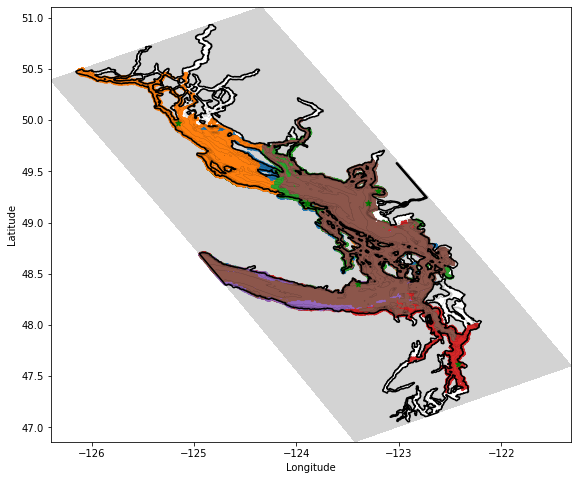

In [18]:
fig, ax = plt.subplots(figsize=(19, 8))
ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_aspect(1/1)
nmin, nmax = 0, -1
#ax.scatter(ds.lon[:, nmax], ds.lat[:, nmax],c='b',s=2)
scatter_particles(ax, N,colors, nmin, nmax, ds.lat)
ax.scatter(clon,clat,c='g', marker='*', linewidths=1)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Text(0.5, 0, 'Longitude')

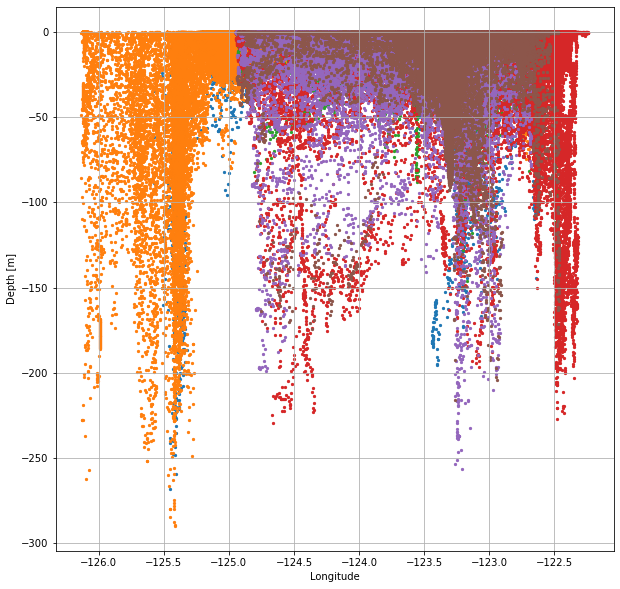

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
scatter_particles(ax, N,colors, nmin, nmax, -ds.z)
ax.grid()
plt.ylabel('Depth [m]')
plt.xlabel('Longitude')

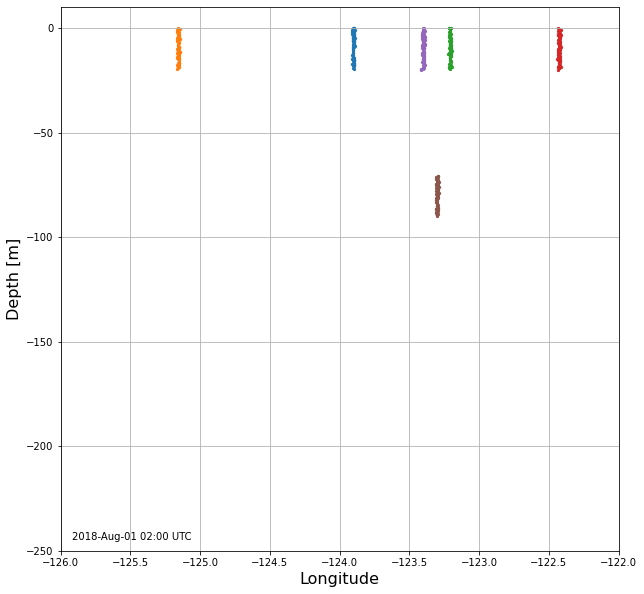

In [20]:
fps = 30
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(xlim=(-126,-122),ylim=(-250,10))
#Include time in animation
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
t.set_text('')
ss = scatter_particles(ax, N,colors, 0, 0, -ds.z)
plt.ylabel('Depth [m]',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
plt.grid()

def update(hour):
    tstamp = ds.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, hour, hour, -ds.z)
    return ss

anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps),repeat=True)
anim
#f = r"/Users/jvalenti/MOAD/animations/depth_storm.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)

In [21]:
###load YT
#ID_yt = "CGlbGgVnbos"
#YouTubeVideo(ID_yt)
###
#Video("/Users/jvalenti/MOAD/analysis-jose/notebooks/results/anim.mp4",embed=True) 

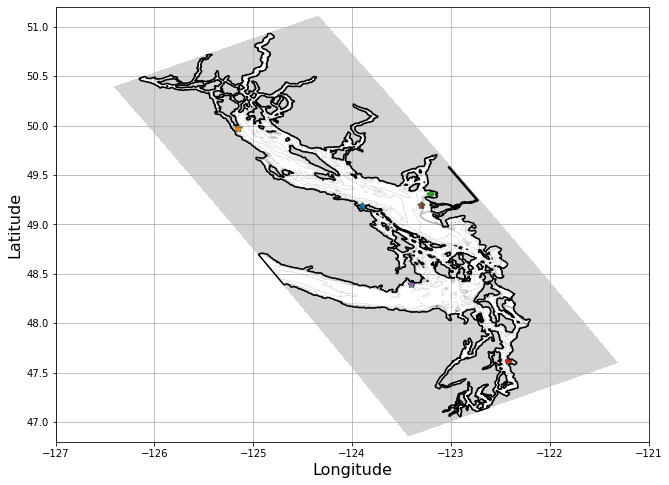

In [21]:
fps = 1
fig = plt.figure(figsize=(19, 8))
ax = plt.axes(xlim=(-127,-121),ylim=(46.8,51.2))

#Include time in animation
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
t.set_text('')

ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.grid()
ax.set_aspect(1/1)
ax.scatter(clon,clat,c='g', marker='*', linewidths=2)
plt.ylabel('Latitude',fontsize=16)
plt.xlabel('Longitude',fontsize=16)
ss = scatter_particles(ax, N,colors, 0,0, ds.lat)

def update(frames):
    global ss
    for scat in ss:
        scat.remove()
    ss = scatter_particles(ax, N,colors, frames,frames, ds.lat)
    return ss


anim = animation.FuncAnimation(fig, update, frames=np.arange(0,len(ds.lon[0,:]),fps))
anim
#f = r"/Users/jvalenti/MOAD/animations/storm.mp4" 
#FFwriter = animation.FFMpegWriter()
#anim.save(f, writer = FFwriter)

In [29]:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
def scatterHD_particles(ax, N,colors, nmin, nmax,yvar):
    scatter=[]
    #N is the number of stations
    #Color is a list of strings picking the desired colors
    #nmin is t0, nmax is tmax
    #yvar is the y coordinate
    
    starts = np.arange(0,N*n,n)
    ends = np.arange(n-1,N*n,n)
    if N < len(colors):
        colors = colors[0:N]
    elif N > len(colors):
        con = 0
        while N > len(colors):
            colors.append(colors[con])
            con+=1
    if nmin==nmax:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin], yvar[starts[i]:ends[i], nmin],c=colors[i],s=5,transform=crs.PlateCarree(),zorder=2))
    else:
        for i in range(N):
            scatter.append(ax.scatter(ds.lon[starts[i]:ends[i], nmin:nmax], yvar[starts[i]:ends[i], nmin:nmax],c=colors[i],s=5,transform=crs.PlateCarree(),zorder=2))
    return scatter

<Figure size 1368x576 with 0 Axes>

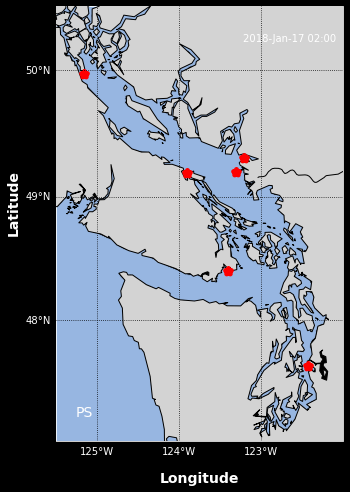

In [31]:
fps = 2
fig = plt.figure(figsize=(19, 8))

# Make map
fig, ax = plt.subplots(figsize=(19, 8), subplot_kw={'projection': crs.Mercator()})

#Include time in animation
t = ax.text(0.65, 0.92, '', transform=ax.transAxes,zorder=5)
t.set_text('')

ax.set_extent([-125.5, -122, 47, 50.5], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', edgecolor='k', facecolor='lightgray'),zorder=3)
ax.add_feature(feature.RIVERS, edgecolor='k',zorder=5)
ax.add_feature(feature.OCEAN,zorder=1)

gl = ax.gridlines(
    linestyle=':', color='k', draw_labels=True,
    xlocs=range(-126, -121), ylocs=range(47, 52),zorder=5)
gl.top_labels, gl.right_labels = False, False
ss=scatterHD_particles(ax, N,colors, 0, 0,ds.lat)
ax.scatter(clon,clat,c='r', marker='*', linewidth=5,transform=crs.PlateCarree(),zorder=4)
ax.text(-0.12, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14,weight="bold")

ax.text(0.1, 0.05, 'PS', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=14)

plt.style.use('dark_background')

def animate(frames):
    tstamp = ds.time[0, frames].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M'))
    global ss
    for scat in ss:
        scat.remove()
    ss=scatterHD_particles(ax, N,colors, frames, frames,ds.lat)


anim = animation.FuncAnimation(fig, animate, frames=np.arange(0,len(ds.lon[0,:]),fps))
f = r"/home/jvalenti/MOAD/animations/PS.mp4" 
FFwriter = animation.FFMpegWriter()
anim.save(f, writer = FFwriter)